In [1]:
import numpy as np
def get_grids_by_corner(corners,grid_size=7):
    top_left, top_right, bot_left, bot_right = corners
    res = np.zeros((grid_size*grid_size))

    width = top_right - top_left + 1
    for i in range(top_left,bot_left+1,grid_size):
        res[i:i+width] = 1
    
    return res

def gridlize(img,grid_size=7):
    h,w = img.shape[0:2]
    delta_w = int(w / grid_size)
    delta_h = int(h / grid_size)
    for i in range(1,grid_size):
        pos_w = delta_w * i
        pos_h = delta_h * i
        img = cv2.line(img,(pos_w,0),(pos_w,h),(0,0,255),2)
        img = cv2.line(img,(0,pos_h),(w,pos_h),(0,0,255),2)
    return img


def draw_box(box,img,color=(0,255,0)):
    box = box.astype('int')
    img = cv2.rectangle(img,tuple(box[:2]),tuple(box[2:]),color,4)
    return img


def highlight_grid(img, gird_idx, grid_size=7):
    h,w = img.shape[0:2]
    delta_w = int(w / grid_size)
    delta_h = int(h / grid_size)
    y = grid_idx // grid_size
    x = grid_idx % grid_size
    
    x_min = x * delta_w
    x_max = x_min + delta_w
    y_min = y * delta_h
    y_max = y_min + delta_h
    
    overlay = img.copy()
    overlay = cv2.rectangle(overlay,(x_min,y_min),(x_max,y_max),(255,0,0),-1)
    alpha = 0.4  # Transparency factor.

    # Following line overlays transparent rectangle over the image
    image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    return image_new



def lower_bound(nums,target):
    start = 0
    end = len(nums) - 1
    pos = 0
    while start <= end:
        mid = int((start+end)/2)
        if nums[mid] <= target:
            pos = mid
            start = mid + 1
        else:
            end = mid - 1
    return pos


def upper_bound(nums,target):
    start = 0
    end = len(nums) - 1
    pos = end
    while start <= end:
        mid = int((start+end)/2)
        if nums[mid] < target:
            start = mid + 1
        else:
            end = mid - 1
            pos = mid
    return pos
        


def find_corner(box,img_size,grid_size=7):
    # make grid
    grids = np.arange(grid_size) / grid_size
    
    h,w = img_size
    x_min,y_min,x_max,y_max = box
    x_min,y_min,x_max,y_max = x_min/w,y_min/h,x_max/w,y_max/h

    res = []
    # top left
    x1 = lower_bound(grids,x_min)
    y1 = lower_bound(grids,y_min)
    res.append(y1*grid_size+x1)

    # top right
    x2 = lower_bound(grids,x_max)
    res.append(y1*grid_size+x2)

    # bot left
    y3  = lower_bound(grids, y_max)
    res.append(y3*grid_size+x1)
    
    # bot right
    res.append(y3*grid_size+y3)

    return res

In [2]:
import h5py
f = h5py.File('/home/luoyp/disk1/grid-feats-vqa/feats/test_all_X101.hdf5','r')

In [3]:
import matplotlib.pyplot as plt
import cv2

path = '/home/data/COCO/DATA/val2014/COCO_val2014_000000100000.jpg'
img = cv2.imread(path)

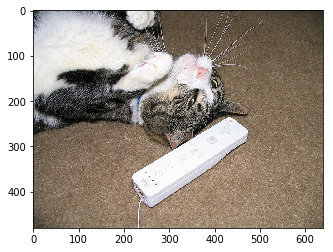

In [4]:
plt.imshow(img[:,:,[2,1,0]])

In [5]:
path = '/home/data/COCO/DATA/test2014/COCO_test2014_000000000001.jpg'
img = cv2.imread(path)
boxes = f['1_boxes'][()]
size = f['1_size'][()]
img = cv2.resize(img,(size[0][1],size[0][0]))

In [6]:
i = iter(list(range(len(boxes))))

0


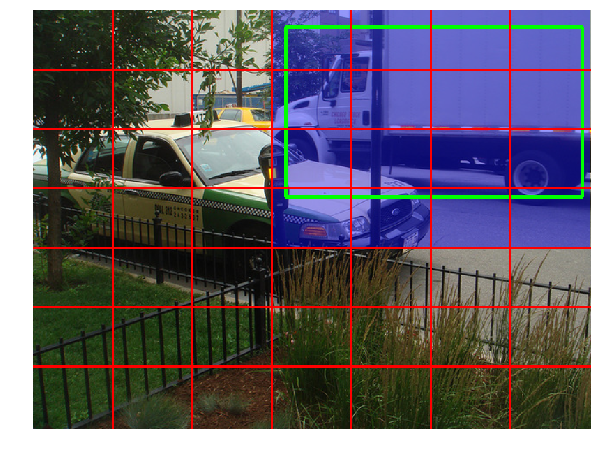

In [7]:
cpimg = img.copy()
idx = next(i)
print(idx)
res = find_corner(boxes[idx],size[0])
grids = get_grids_by_corner(res)
grid_idxes = np.arange(49)[grids!=0]
for grid_idx in grid_idxes:
    cpimg = highlight_grid(cpimg,grid_idx)
cpimg = draw_box(boxes[idx],cpimg)
cpimg = gridlize(cpimg)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cpimg[:,:,[2,1,0]])

In [8]:
f.close()

In [9]:
import h5py
import numpy as np
from tqdm import tqdm
grid_size = 7
f = h5py.File('/home/luoyp/disk1/grid-feats-vqa/feats/test_all_X101.hdf5','a')
keys = list(f.keys())
for key in tqdm(keys):
    if 'features' in key:
        image_id = key.split('_')[0]
    else:
        continue
    boxes = f['{}_boxes'.format(image_id)][()]
    size=  f['{}_size'.format(image_id)][()]
    
    mask = np.zeros((len(boxes),grid_size*grid_size))
    for i,box in enumerate(boxes):
        res = find_corner(box,size[0])
        grids = get_grids_by_corner(res)
        mask[i] = grids
    f.create_dataset('{}_mask'.format(image_id),data=mask)
    
f.close()

100%|██████████| 163100/163100 [06:16<00:00, 432.96it/s]


In [4]:
f.close()